smm4h data: (1712, 2)
smm4h data after filtering: (1710, 2)
SOC count in SMM4H:  soc_code
10037175    287
10018065    235
10029205    212
10017947     63
10028395     58
10022891     54
10027433     48
10040785     28
10038738     22
10022117     16
10015919     16
10038604     10
10047065     10
10021428      8
10041244      7
10007541      7
10038359      6
10021881      5
10013993      4
10019805      2
10042613      2
10029104      2
10077536      1
10010331      1
10014698      1
Name: count, dtype: Int64


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


SOC count in CADEC:  soc_code
10028395    962
10018065    654
10037175    401
10017947    300
10029205    286
10040785    184
10007541     92
10038738     91
10022891     82
10015919     67
10038604     59
10038359     50
10022117     35
10047065     25
10013993     16
10019805     15
10041244      7
10027433      6
10021881      5
10021428      4
10014698      3
10005329      3
10029104      1
Name: count, dtype: int64
SMM4H :                             ade  soc_code  label
1                     allergies  10021428     13
2               HURT YOUR Liver  10019805     19
3                            AD  10037175      0
4                         focus  10029205      2
5                          died  10018065      1
...                         ...       ...    ...
1703                 chest hurt  10018065      1
1704   got ten minutes of sleep  10037175      0
1706                  Nosebleed  10038738      8
1708  never have another orgasm  10037175      0
1710        gain so much weig

C:\Users\fd\anaconda3\envs\torch\Lib\site-packages\transformers\tokenization_utils_base.py:2888: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to

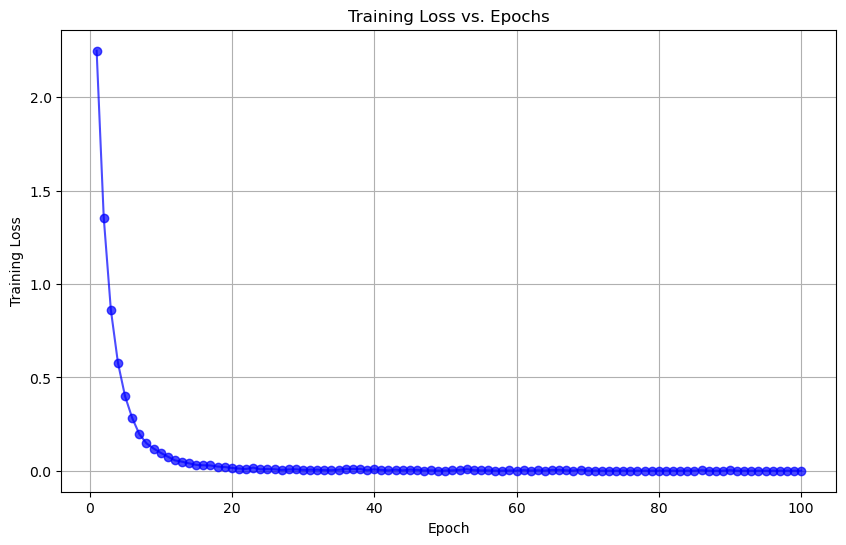

In [1]:
#install packages
!pip install transformers
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import random

import logging
import random
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from tqdm import tqdm

def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    classes, counts = np.unique(y, return_counts=True)
    if test_size == 0:
        return X, [], y, []
    # Find classes with only one or two instances
    small_classes = classes[counts < 5]

    # Separate out the instances of small classes
    large_class_mask = ~np.isin(y, small_classes)
    X_large = X[large_class_mask]
    y_large = y[large_class_mask]
    X_small = X[~large_class_mask]
    y_small = y[~large_class_mask]

    # Perform stratified split on the larger classes dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_large, y_large, test_size=test_size, random_state=random_state, stratify=y_large
    )

    # Randomly assign instances of small classes to training or testing sets
    for i in range(len(X_small)):
        if np.random.rand() < test_size:
            X_test = np.vstack([X_test, X_small[i]])
            y_test = np.hstack([y_test, y_small[i]])
        else:
            X_train = np.vstack([X_train, X_small[i]])
            y_train = np.hstack([y_train, y_small[i]])

    return X_train, X_test, y_train, y_test

#evaluation
def accuracy_per_class(predictions, true_vals):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()

    accuracy_dict = {}
    count_dict = {}

    for label in np.unique(labels_flat):
        y_preds = pred_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy_dict[label] = np.sum(y_preds == y_true) / len(y_true) if len(y_true) > 0 else 0
        count_dict[label] = len(y_true)

    return accuracy_dict, count_dict

# Configure logging
logging.basicConfig(filename='cadec_all_finetuning_training_epochs_100.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

class TQDMLoggingWrapper(tqdm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logger = logger

    def display(self, msg=None, pos=None):
        if msg is not None:
            self.logger.info(msg)
        super().display(msg, pos)

    def update(self, n=1):
        super().update(n)
        desc = self.format_dict.get('desc', 'No description')
        postfix = self.format_dict.get('postfix', '')
        self.logger.info(f'{desc} - {postfix}')

    def set_description(self, desc=None, refresh=True):
        super().set_description(desc, refresh)
        if desc:
            self.logger.info(f'Set description: {desc}')


# Function to evaluate the model
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

#Read data from git:
#https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADENormalization/Data/CADEC/3.csv
# URL of the CSV file
cadec_csv_url = "https://raw.githubusercontent.com/FANMISUA/TweetAENormalization/main/ADENormalization/Data/CADEC/3.csv"
# read data from smm4h
smm4h_csv_url = "https://raw.githubusercontent.com/FANMISUA/ADE_Norm/main/Data/smm4h_soc.tsv"

# top6SMM4H = [10037175, 10018065,10029205, 10017947, 10028395, 10022891]
# top6label_dict = {
#     10037175: 0,
#     10018065: 1,
#     10029205: 2,
#     10017947: 3,
#     10028395: 4,
#     10022891: 5
# }

allSMM4H = [10037175, 10018065,10029205, 10017947, 10028395, 10022891, 10027433, 10040785, 10038738, 10022117, 10015919, 10038604, 10047065, 
            10021428,10041244, 10007541, 10038359, 10021881, 10013993, 10019805, 10042613, 10029104, 10077536, 10010331, 10014698]

label_dict = {
    10037175: 0,
    10018065: 1,
    10029205: 2,
    10017947: 3,
    10028395: 4,
    10022891: 5,
    10027433: 6,
    10040785: 7,
    10038738: 8,
    10022117: 9,
    10015919: 10,
    10038604: 11,
    10047065: 12,
    10021428: 13,
    10041244: 14,
    10007541: 15,
    10038359: 16,
    10021881: 17,
    10013993: 18,
    10019805: 19,
    10042613: 20,
    10029104: 21,
    10077536: 22,
    10010331: 23,
    10014698: 24
}


# Read the CSV file into a pandas DataFrame
column_names = ["ade", "soc_code"]
smm4h_all = pd.read_csv(smm4h_csv_url,names=column_names, sep = '\t', header=None)
print("smm4h data:",smm4h_all.shape)

smm4h_all['soc_code'] = pd.to_numeric(smm4h_all['soc_code'], errors='coerce').astype('Int64')
smm4h_all = smm4h_all[smm4h_all['soc_code'] != 0]

smm4h_unique = smm4h_all.drop_duplicates(subset='ade')

print("smm4h data after filtering:",smm4h_all.shape)
smm4h_soc_code_counts = smm4h_unique['soc_code'].value_counts()
# Sort the counts from high to low and print the result
print("SOC count in SMM4H: ",smm4h_soc_code_counts)
# Filter DataFrame
smm4h_filtered_data3 = smm4h_unique[smm4h_unique['soc_code'].isin(allSMM4H)]
# filtered_data6 = cadec_unique[cadec_unique['soc_code'].isin(top6SMM4H)]

# Select only the Term and SOC columns
allinSMM4H = smm4h_filtered_data3[['ade', 'soc_code']]
# CADECtop6inSMM4H = filtered_data6[['ade', 'soc_code']]

# Read the CSV file into a pandas DataFrame
column_names = ["TT", "llt_code", "ade", "soc_code"]
cadec_all = pd.read_csv(cadec_csv_url,names=column_names, header=None)

# Remove duplicate rows based on the 'ade' column
cadec_unique = cadec_all.drop_duplicates(subset='ade')

# Display the resulting DataFrame
# print("clean cadec data:",cadec_unique.shape)
# Count occurrences of each 'soc_code'
cadec_soc_code_counts = cadec_unique['soc_code'].value_counts()
# Sort the counts from high to low and print the result
print("SOC count in CADEC: ",cadec_soc_code_counts)


# Filter DataFrame
cadec_filtered_data3 = cadec_unique[cadec_unique['soc_code'].isin(allSMM4H)]
# filtered_data6 = cadec_unique[cadec_unique['soc_code'].isin(top6SMM4H)]

# Select only the Term and SOC columns
CADECallinSMM4H = cadec_filtered_data3[['ade', 'soc_code']]
# CADECtop6inSMM4H = filtered_data6[['ade', 'soc_code']]


# For SMM4H data
df1 = allinSMM4H.copy()
df1.loc[:, 'label'] = df1['soc_code'].map(label_dict)

# For CADEC data
df2 = CADECallinSMM4H.copy()
df2.loc[:, 'label'] = df2['soc_code'].map(label_dict)

print("SMM4H :",df1)
print("CADEC :",df2)

#cadec data
df = df2
# print(df.shape)

# Define the random seeds and other parameters
seed_values = list(range(2, 4, 2))

# fix batch_size 16, learning rate 1e-5; Finetuning epochs
learning_rates = [1e-5]
batch_sizes = [16]
epochs_list = [100]
# Results storage
results = []
# Store the training losses across all splits
all_training_losses = []
# Main loop over seed values
# Training loop
for seed_val in seed_values:
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
    training_losses = []
    


    # Training loop for grid search
    for lr in learning_rates:
      for batch_size in batch_sizes:
          for epochs in epochs_list:
              # Data preparation
                tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
                encoded_data_train = tokenizer.batch_encode_plus(
                    df.ade.values,
                    add_special_tokens=True,
                    return_attention_mask=True,
                    pad_to_max_length=True,
                    max_length=256,
                    return_tensors='pt'
                )
                
                input_ids_train = encoded_data_train['input_ids']
                attention_masks_train = encoded_data_train['attention_mask']
                labels_train = torch.tensor(df.label.values)
                
                dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
                dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
                
                model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_dict), output_attentions=False, output_hidden_states=False)
                optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
                scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train) * epochs)
                
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                model.to(device)
                
                # Training loop
                for epoch in TQDMLoggingWrapper(range(1, epochs+1), desc='Epoch Progress'):
                    model.train()
                    loss_train_total = 0
                
                    progress_bar = TQDMLoggingWrapper(dataloader_train, desc=f'Epoch {epoch}', leave=False, disable=False)
                    for batch in progress_bar:
                        model.zero_grad()
                        batch = tuple(b.to(device) for b in batch)
                        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                
                        outputs = model(**inputs)
                        loss = outputs[0]
                        loss_train_total += loss.item()
                        loss.backward()
                
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()
                        scheduler.step()
                
                        progress_bar.set_postfix({'training_loss': f'{loss.item()/len(batch):.3f}'})
                
                    loss_train_avg = loss_train_total / len(dataloader_train)
                    training_losses.append(loss_train_avg)
                
                    logger.info(f'Epoch {epoch}: Training loss = {loss_train_avg:.4f}')
                
                all_training_losses.append(training_losses)

# Calculate the average training loss and standard deviation across all splits
average_training_losses = np.mean(all_training_losses, axis=0)
std_training_losses = np.std(all_training_losses, axis=0)

# Save the training losses to a file
with open('cadec_all_training_losses.txt', 'w') as f:
    for epoch, loss in enumerate(average_training_losses, 1):
        f.write(f'Epoch {epoch}: {loss:.4f}\n')

# Plotting training loss
epochs_range = range(1, epochs + 1)
mean_losses = np.mean(all_training_losses, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, mean_losses, '-o', color='b', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.savefig('cadec_all_trainingloss_vs_epochs.png')
plt.show()